In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

#Measures
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix

#Plots
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
import matplotlib
font = {'family' : 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

# Measures

In [3]:
#-------Class Overlap--------

def class_overlap(X, y, return_points=False, threshold_value=0.05):
    #model = SVC(kernel='linear', C=1e5, random_state=42)
    model = LogisticRegression(penalty="none", max_iter=5000,random_state=42)
    model.fit(X, y)
    decision_values = model.decision_function(X)
    threshold = decision_values.ptp() * threshold_value
    inside_boundary_indices = np.where((decision_values >= -threshold) & (decision_values <= threshold))[0]
    if(return_points):
        points_inside_boundary = X.iloc[inside_boundary_indices]
        return points_inside_boundary
    else:
        n_points_inside_boundary = len(inside_boundary_indices)
        print(f"Points inside boundary: {n_points_inside_boundary}\nClass Overlap: {n_points_inside_boundary/len(X)}")
        return n_points_inside_boundary/len(X)

In [4]:
def edit_class_overlap(X, y, factor, threshold_value=0.03, strategy='SMOTE'):
    points_inside_boundary_X = class_overlap(X,y,True,threshold_value=threshold_value)
    points_inside_boundary_y = y.iloc[points_inside_boundary_X.index]

    points_outside_boundary_X = X.loc[X.index.difference(points_inside_boundary_X.index)]
    points_outside_boundary_y = y.loc[X.index.difference(points_inside_boundary_X.index)]

    n_point = len(points_inside_boundary_X)
    if strategy == 'Undersampler':
        undersampler = RandomUnderSampler(sampling_strategy= {value: int(count * factor) for value, count in points_outside_boundary_y.value_counts().items()}  , random_state=42)
        X_under, y_under = undersampler.fit_resample(points_outside_boundary_X, points_outside_boundary_y)
        X_new = pd.concat([X_under, points_inside_boundary_X]).reset_index(drop=True)
        y_new = pd.concat([y_under, points_inside_boundary_y]).reset_index(drop=True)
    else:
        if strategy == 'SMOTE':
            oversampler = SMOTE(sampling_strategy={value: int(count * factor) for value, count in points_inside_boundary_y.value_counts().items()}, random_state=42)
        elif strategy == 'Random':
            oversampler = RandomOverSampler(sampling_strategy=dict(points_inside_boundary_y.value_counts() * factor), random_state=42)
        elif strategy == 'ADASYN':
            oversampler = ADASYN(sampling_strategy={value: int(count * factor) for value, count in points_inside_boundary_y.value_counts().items()}, random_state=42)
        else:
            raise ValueError("Invalid strategy. Supported strategies are: 'SMOTE', 'Random', 'ADASYN'")

        X_over, y_over = oversampler.fit_resample(points_inside_boundary_X, points_inside_boundary_y)
        X_new = pd.concat([X.drop(points_inside_boundary_X.index), X_over]).reset_index(drop=True)
        y_new = pd.concat([y.drop(points_inside_boundary_X.index), y_over]).reset_index(drop=True)


    return X_new, y_new


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Points inside boundary: 44
Class Overlap: 0.22


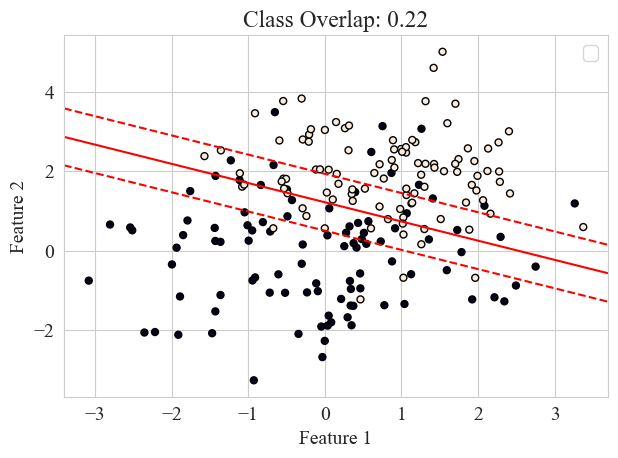

In [5]:
# Example data (replace with your actual data)
x1_samples = np.random.multivariate_normal([0, 0], [[2, 0], [0, 2]], 100)
x2_samples = np.random.multivariate_normal([1, 2], [[1, 0], [0, 1]], 100)

# Combine data from both classes
X = np.concatenate((x1_samples, x2_samples), axis=0)
Y = np.array([0] * 100 + [1] * 100)

# Fit an SVM model with a linear kernel
#model = svm.SVC(kernel='linear',C=1e5, random_state=1234)
model = LogisticRegression(penalty="none", max_iter=5000,random_state=1234)
model.fit(X, Y)

# Plot the decision boundary
plt.scatter(X[:, 0], X[:, 1],c=Y,marker='o', edgecolor="k",s=25)
#plt.scatter(x2_samples[:, 0], x2_samples[:, 1],marker='o', label='Class 2')

#plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired, edgecolors='k', marker='o', s=50, label='Data points')

# Plot the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])

# Plot decision boundary and margins
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, colors='red', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

# Highlight support vectors
#plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', marker='o', label='Support Vectors')

plt.title(f'Class Overlap: {class_overlap(X,Y)}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.tight_layout()
#plt.savefig(f'class_overlap_.svg', format='svg')
plt.show()

In [6]:
measures_steps = {
    'Class Overlap': [1,2, 4,8,24]
}
n_steps = len(list(measures_steps.values())[0])
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}
classifier_names = list(classifiers.keys())

metrics = {
    'Accuracy': np.zeros((len(classifiers), n_steps)),
    'Precision': np.zeros((len(classifiers), n_steps)),
    'Recall': np.zeros((len(classifiers), n_steps)),
    'F1 Score': np.zeros((len(classifiers), n_steps))
}

# Dataset

In [7]:
heart_attack = pd.read_csv('dataset/heart_attack.csv')
heart_attack = heart_attack.sample(frac=1, random_state=42).reset_index(drop=True)
X = heart_attack.drop('output', axis=1)
y = heart_attack['output']
dataset_name = 'heart_attack'
measures_steps = {
    'Class Overlap': [1,3,6,12,24]
}
strategy = 'SMOTE'

In [13]:
marketing_campaign = pd.read_csv('dataset/marketing_campaign.csv',sep=';').sample(frac=1,random_state=42).reset_index(drop=True)
marketing_campaign = marketing_campaign.dropna()
marketing_campaign= marketing_campaign.reset_index(drop=True)
X = marketing_campaign.drop(['Response', 'ID', 'Dt_Customer'], axis=1)
y = marketing_campaign['Response']



enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])

dataset_name = 'marketing_campaign'
measures_steps = {
    'Class Overlap': [1,3, 6,9,16]
}
strategy = 'SMOTE'

In [16]:
heart_failure = pd.read_csv('dataset/heart_failure.csv')
X = heart_failure.drop(['HeartDisease'], axis=1)
y = heart_failure['HeartDisease']


enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])


dataset_name = 'heart_failure'
measures_steps = {
    'Class Overlap': [1,4,7,10,18]
}
strategy = 'SMOTE'

In [19]:
airline_passenger = pd.read_csv('dataset/airline_passenger.csv')
airline_passenger.dropna(inplace=True)
airline_passenger = airline_passenger.reset_index(drop=True)

X = airline_passenger.drop(['satisfaction','Unnamed: 0','id'], axis=1)
y = airline_passenger['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1})


enc = LabelEncoder()
for i in X.columns:
    if X[i].dtype == "object":
        X[i]=enc.fit_transform(X[i])


dataset_name = 'airline_passenger'
measures_steps = {
    'Class Overlap': [0,0.2,0.4,0.6,0.8]
}
strategy = 'Undersampler'

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

measure_value = []
for k, measure_steps in enumerate(measures_steps):

    for i, step in enumerate(measures_steps.get(measure_steps)):


        if(i==0):
            X_train_new, y_train_new = X_train, y_train
        else:
            X_train_new, y_train_new = edit_class_overlap(X_train, y_train, step,strategy=strategy)

        measure_value.append(class_overlap(X_train_new, y_train_new))

        for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            # Standardize the features (optional but often recommended)
            scaler = StandardScaler()
            train_X_scaled = scaler.fit_transform(X_train_new)
            test_X_scaled = scaler.transform(X_test)

            # Train the classifier
            classifier.fit(train_X_scaled, y_train_new)

            # Make predictions on the fixed test set
            predictions = classifier.predict(test_X_scaled)
            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = accuracy_score(y_test, predictions)
            metrics['Precision'][j, i] = precision_score(y_test, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y_test, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y_test, predictions, average='weighted')

Points inside boundary: 2903
Class Overlap: 0.1601655172413793
Points inside boundary: 1763
Class Overlap: 0.3516856173947736
Points inside boundary: 1996
Class Overlap: 0.2407429743094922
Points inside boundary: 2186
Class Overlap: 0.18895323709914427
Points inside boundary: 2469
Class Overlap: 0.1662962214588806


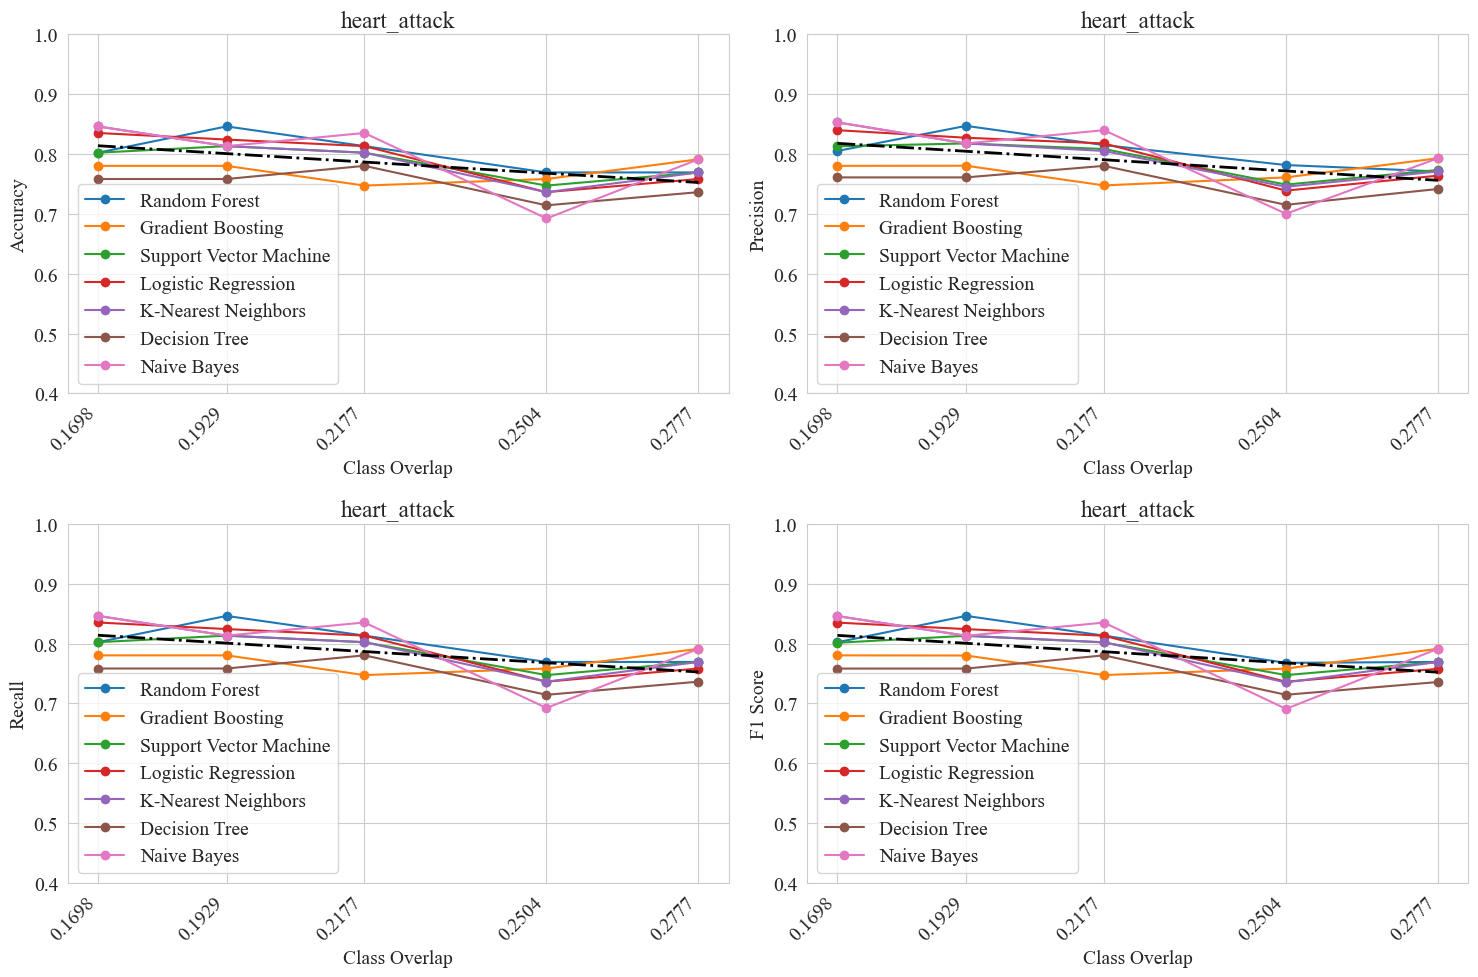

In [9]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/class_overlap_{dataset_name}.svg', format='svg')
plt.show()

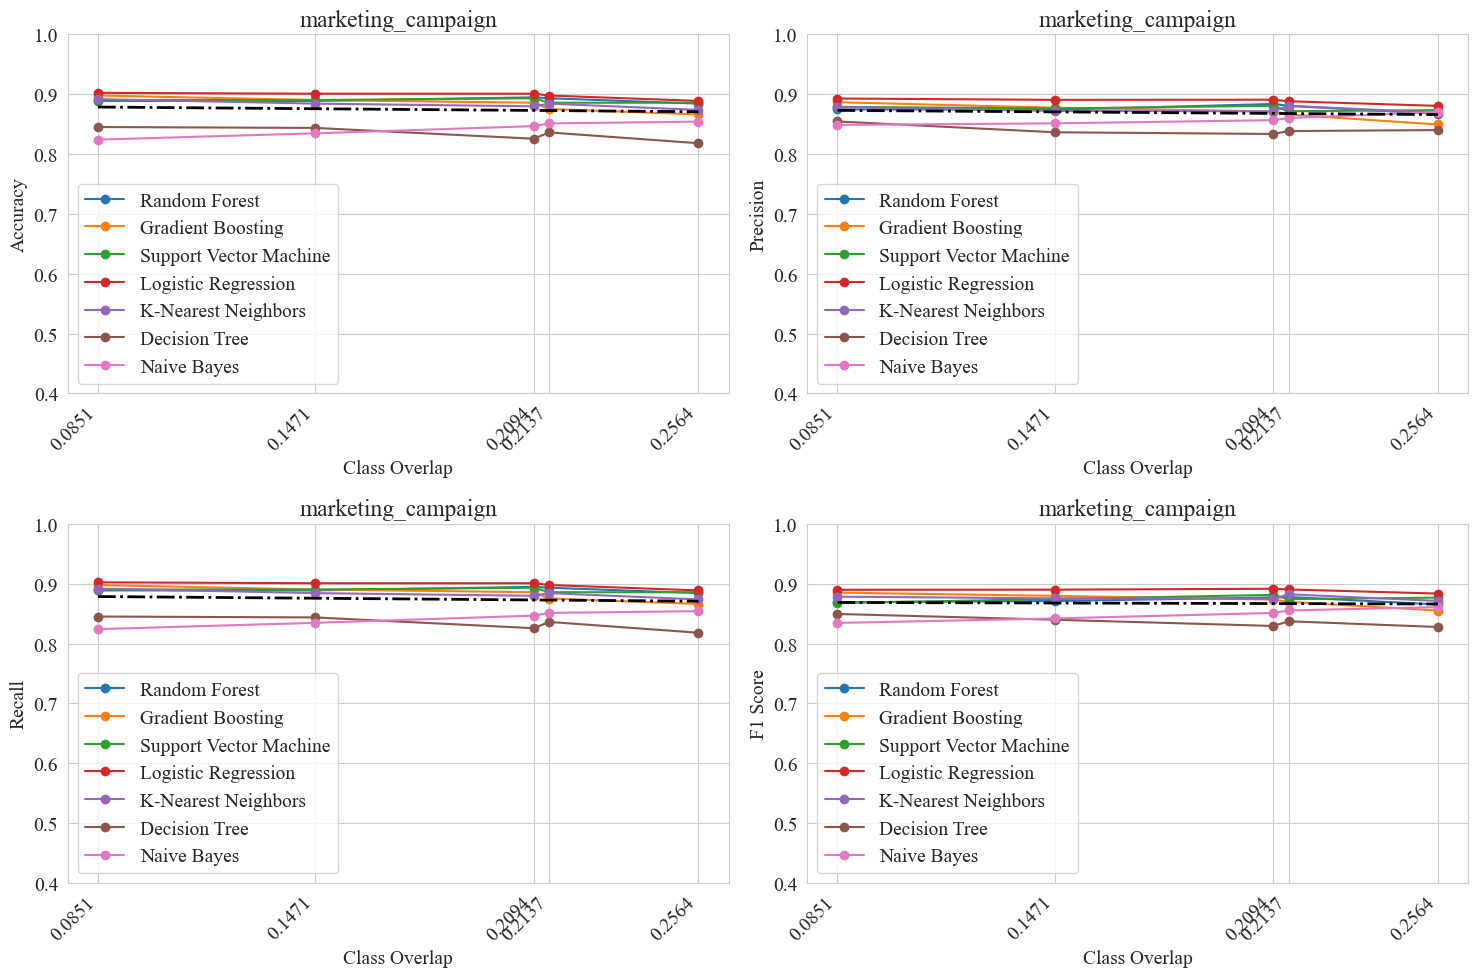

In [15]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/class_overlap_{dataset_name}.svg', format='svg')
plt.show()

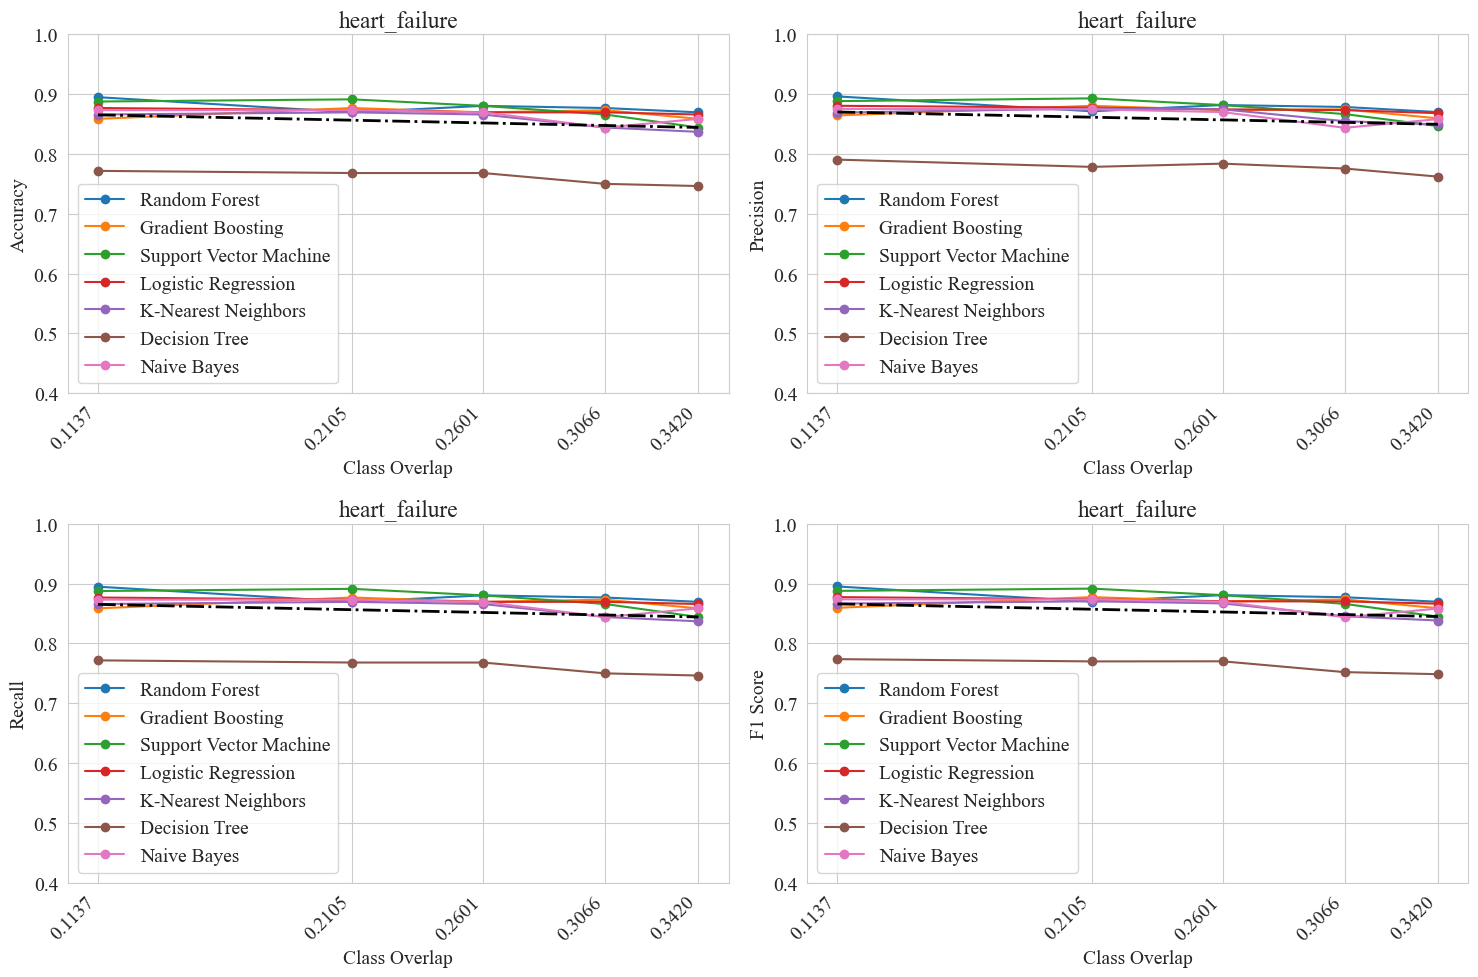

In [18]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/class_overlap_{dataset_name}.svg', format='svg')
plt.show()

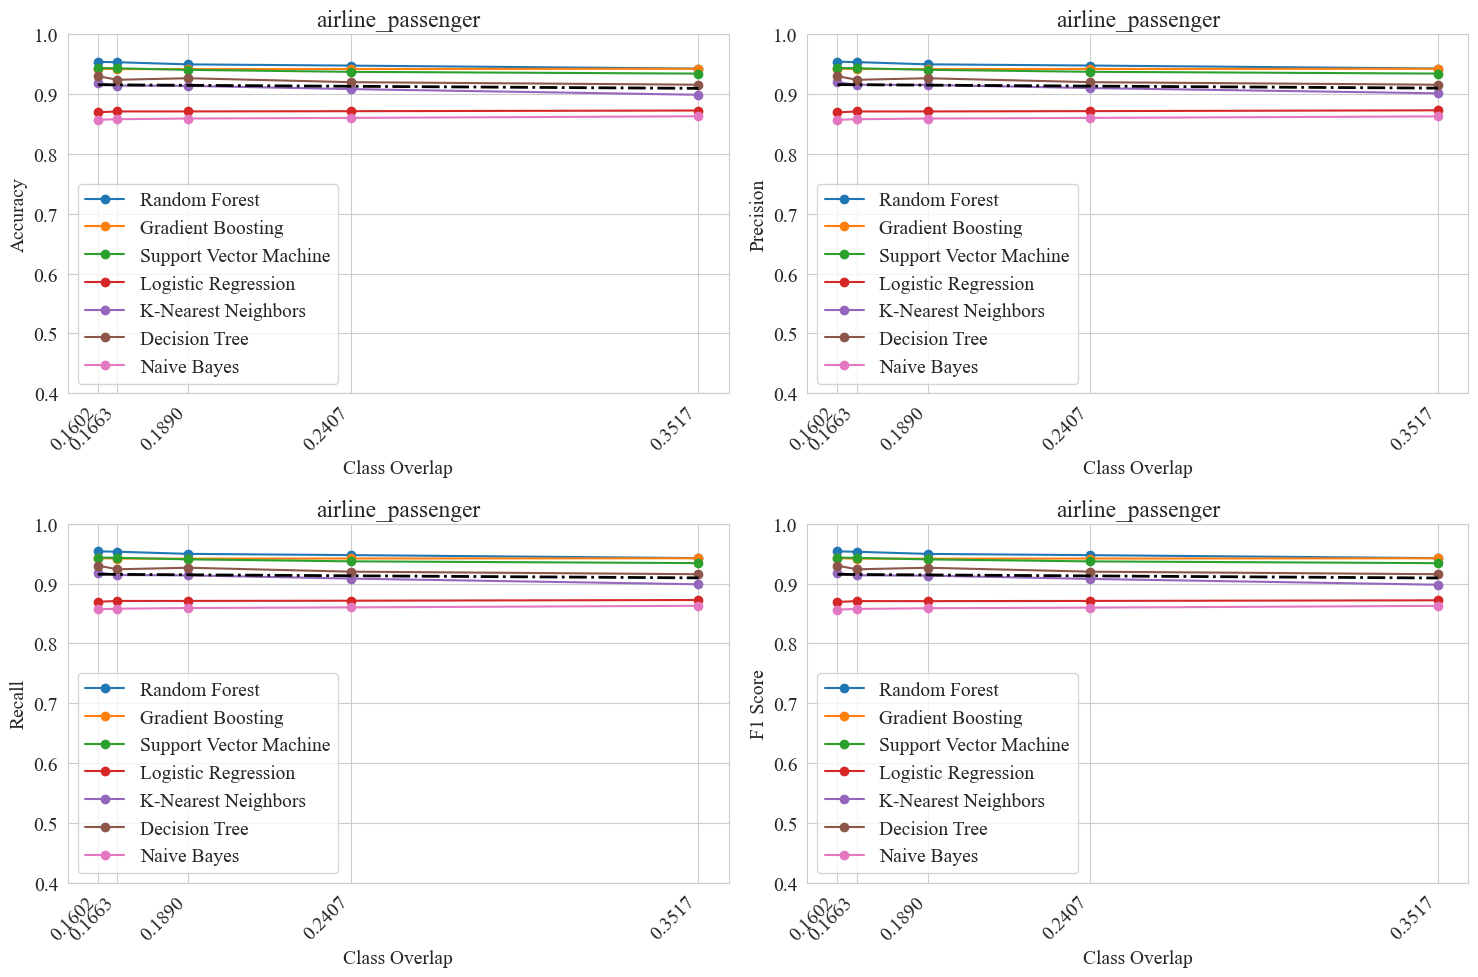

In [21]:
# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/class_overlap_{dataset_name}.svg', format='svg')
plt.show()

In [22]:
measure_value = []
for k, measure_steps in enumerate(measures_steps):

    for i, step in enumerate(measures_steps.get(measure_steps)):

        X, y = make_classification(
                    n_samples=1000,  # Total number of samples
                    n_features=20,    # Number of features
                    n_informative=3, # Number of informative features (set to n_features for simplicity)
                    n_redundant=0,   # Number of redundant features
                    n_clusters_per_class=2, # Number of clusters per class
                    class_sep=step,   # Separation between classes
                    random_state=42
                )
        X_train_new, X_test, y_train_new, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


        measure_value.append(class_overlap(X_train_new, y_train_new))

        for j, (classifier_name, classifier) in enumerate(classifiers.items()):
            # Standardize the features (optional but often recommended)
            scaler = StandardScaler()
            train_X_scaled = scaler.fit_transform(X_train_new)
            test_X_scaled = scaler.transform(X_test)

            # Train the classifier
            classifier.fit(train_X_scaled, y_train_new)

            # Make predictions on the fixed test set
            predictions = classifier.predict(test_X_scaled)
            # Calculate metrics and store in the metrics dictionary
            metrics['Accuracy'][j, i] = accuracy_score(y_test, predictions)
            metrics['Precision'][j, i] = precision_score(y_test, predictions, average='weighted')
            metrics['Recall'][j, i] = recall_score(y_test, predictions, average='weighted')
            metrics['F1 Score'][j, i] = f1_score(y_test, predictions, average='weighted')


Points inside boundary: 160
Class Overlap: 0.22857142857142856
Points inside boundary: 223
Class Overlap: 0.31857142857142856
Points inside boundary: 162
Class Overlap: 0.23142857142857143
Points inside boundary: 144
Class Overlap: 0.2057142857142857
Points inside boundary: 119
Class Overlap: 0.17


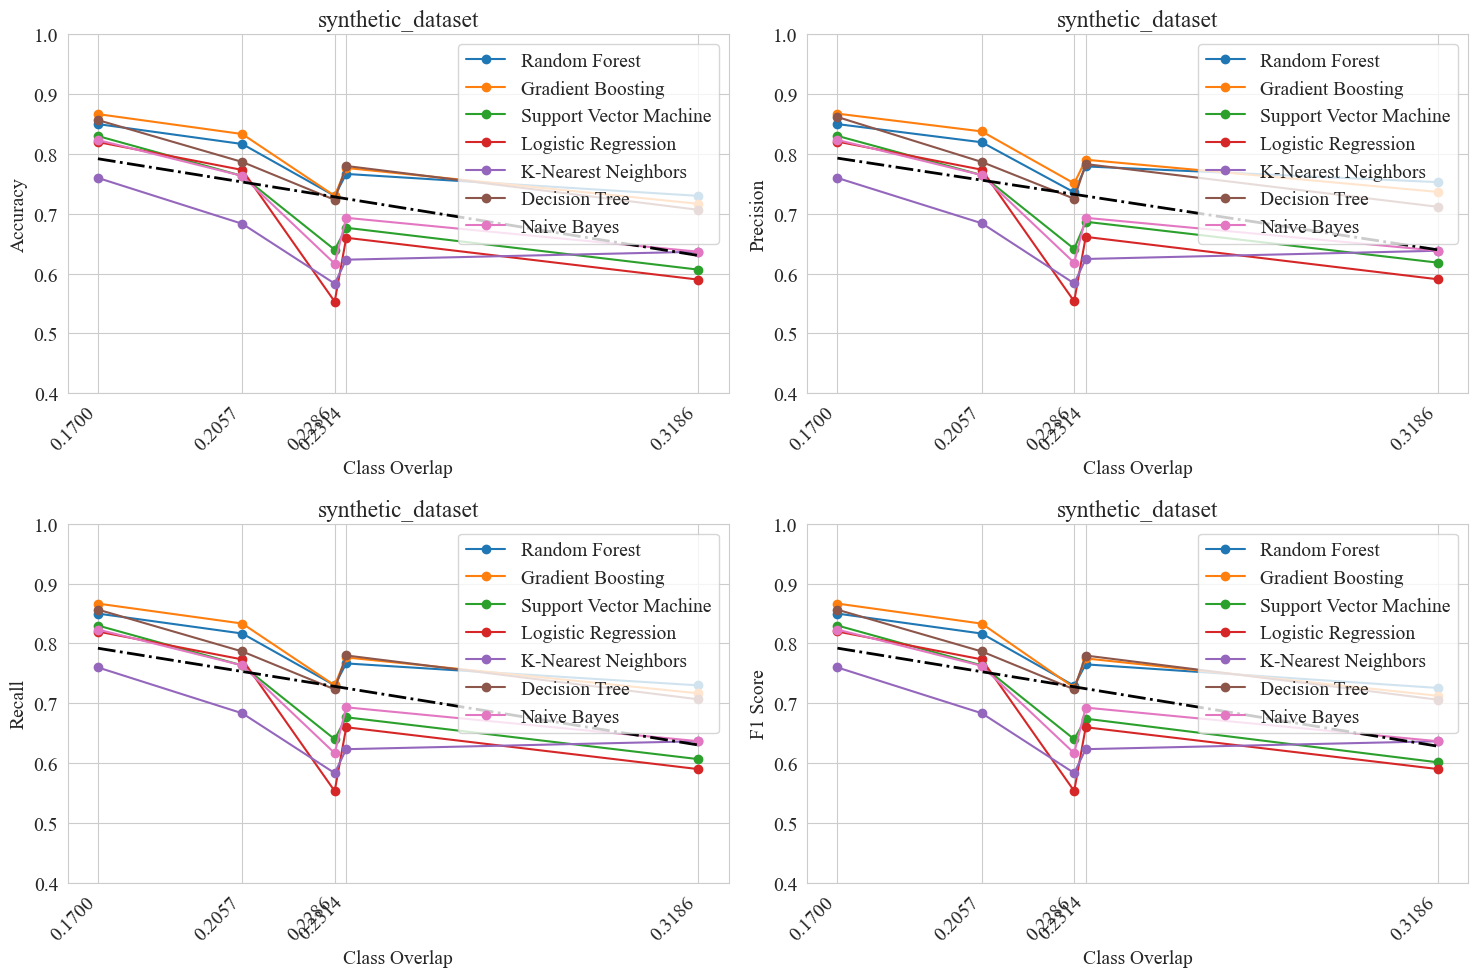

In [23]:
dataset_name = 'synthetic_dataset'

# Plotting
plt.figure(figsize=(15, 10))
for k, metric in metrics.items():
    plt.subplot(2, 2, list(metrics.keys()).index(k) + 1)
    for i in range(len(classifiers)):

        z = sorted(zip(measure_value, metric[i, :]))
        x=[j[0] for j in z]
        y=[j[1] for j in z]

        plt.plot(x, y, label=classifier_names[i], marker='o')
        plt.title(f'{dataset_name}')
        plt.xticks(x)
        plt.xticks(rotation=45, ha='right')

        plt.xlabel(list(measures_steps)[0])
        plt.ylabel(k)
        plt.legend()
    z = sorted(zip(measure_value, np.mean(metric,axis=0)))
    x=[j[0] for j in z]
    y=[j[1] for j in z]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x),color='black',linestyle='-.',linewidth=2)
    plt.ylim(0.4,1)

plt.tight_layout()
plt.savefig(f'plots/class_overlap_{dataset_name}.svg', format='svg')
plt.show()
